# Convolutional Neural Networks

## Data Preparation

In [1]:
# Importing the libraries
import os
import torch
import torchvision
from torchvision.utils import make_grid

import numpy as np

In [2]:
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor, Normalize

In [3]:
# Transform to normalize the data and convert to a tensor
transform = Compose([ToTensor(),
    Normalize((0.5,), (0.5,))
    ])

# Download the data
dataset = FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)

100%|██████████| 26421880/26421880 [00:59<00:00, 443052.44it/s]


Extracting MNIST_data/FashionMNIST\raw\train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 208765.27it/s]


Extracting MNIST_data/FashionMNIST\raw\train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:10<00:00, 430046.54it/s]


Extracting MNIST_data/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST\raw



## Data Exploration

In [4]:
print(dataset.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [5]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: {} ({})'.format(dataset.classes[label], label))
    plt.imshow(img.squeeze(), cmap='Greys_r')
    plt.axis(False)

Label: Dress (3)


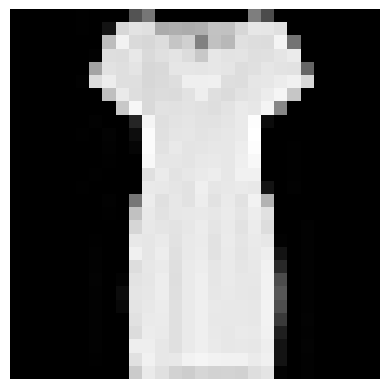

In [6]:
show_example(*dataset[20])

Label: Sneaker (7)


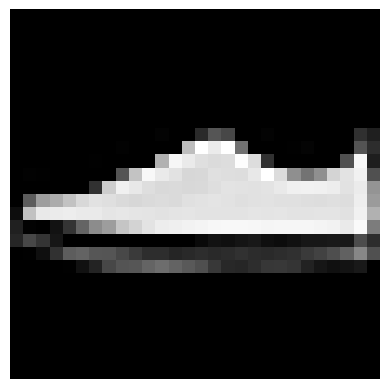

In [7]:
show_example(*dataset[20000])

## Creating Training and Validation Datasets

In [8]:
def split_indices(n, val_frac, seed):
    # Determine the size of the validation set
    n_val = int(val_frac * n)
    np.random.seed(seed)
    # Create random permutation between 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [9]:

val_frac = 0.2 ## Set the fraction for the validation set
rand_seed = 123 ## Set the random seed

train_indices, val_indices = split_indices(len(dataset), val_frac, rand_seed)
print("#samples in training set: {}".format(len(train_indices)))
print("#samples in validation set: {}".format(len(val_indices)))

#samples in training set: 48000
#samples in validation set: 12000


In [10]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [11]:

batch_size = 32 ## Set the batch size

In [12]:
# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                     batch_size,
                     sampler=train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset,
                   batch_size,
                   sampler=val_sampler)

Plot images in a sample batch of data.

In [13]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, 8).permute(1, 2, 0), cmap='Greys_r')
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


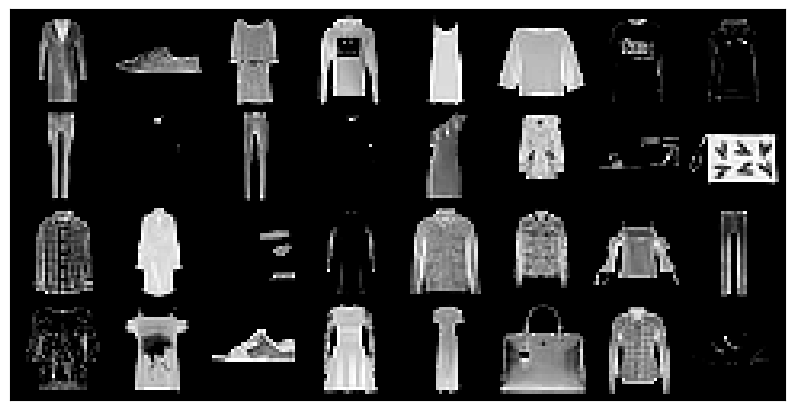

In [14]:
show_batch(train_dl)

## Model

In [16]:

import torch.nn as nn
import torch.nn.functional as F

from torchinfo import summary

In [17]:
class ImageClassifierNet(nn.Module):
    def __init__(self, n_channels=3):
        super(ImageClassifierNet, self).__init__()
        self.seq = nn.Sequential(nn.Conv2d(1, 8, 3, 1, 1),
                                 nn.BatchNorm2d(8),
                                 nn.ReLU(),
                                 nn.Conv2d(8, 8, 3, 1, 1), 
                                 nn.BatchNorm2d(8),
                                 nn.ReLU(),
                                 nn.MaxPool2d(2, 2), 
                                 nn.Conv2d(8, 16, 3, 1, 1),
                                 nn.BatchNorm2d(16),
                                 nn.ReLU(), 
                                 nn.Conv2d(16, 16, 3, 1, 1),
                                 nn.BatchNorm2d(16),
                                 nn.ReLU(), 
                                 nn.MaxPool2d(2, 2),
                                 nn.Conv2d(16, 32, 3, 1, 1), 
                                 nn.Conv2d(32, 32, 3, 1, 1), 
                                 nn.BatchNorm2d(32),
                                 nn.ReLU(),
                                 nn.AvgPool2d(7), 
                                 nn.Flatten(),
                                 nn.Linear(32, 16),
                                 nn.BatchNorm1d(16),
                                 nn.ReLU(),
                                 nn.Linear(16, 10)
        )
        
    def forward(self, X):
        return self.seq(X)
        

In [18]:
model = ImageClassifierNet()

In [19]:
summary(model, input_size=(batch_size, 1, 28, 28))

c:\ProgramData\Anaconda3\lib\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
c:\ProgramData\Anaconda3\lib\site-packages\torch\storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifierNet                       [32, 10]                  --
├─Sequential: 1-1                        [32, 10]                  --
│    └─Conv2d: 2-1                       [32, 8, 28, 28]           80
│    └─BatchNorm2d: 2-2                  [32, 8, 28, 28]           16
│    └─ReLU: 2-3                         [32, 8, 28, 28]           --
│    └─Conv2d: 2-4                       [32, 8, 28, 28]           584
│    └─BatchNorm2d: 2-5                  [32, 8, 28, 28]           16
│    └─ReLU: 2-6                         [32, 8, 28, 28]           --
│    └─MaxPool2d: 2-7                    [32, 8, 14, 14]           --
│    └─Conv2d: 2-8                       [32, 16, 14, 14]          1,168
│    └─BatchNorm2d: 2-9                  [32, 16, 14, 14]          32
│    └─ReLU: 2-10                        [32, 16, 14, 14]          --
│    └─Conv2d: 2-11                      [32, 16, 14, 14]          2,320
│    └─B

## GPU Training

In [46]:
def get_default_device():
    """Use GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [22]:
device = get_default_device()

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

to_device(model, device)

ImageClassifierNet(
  (seq): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

## Train the model

In [45]:
def train_model(n_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr):
    """
    Trains the model on a dataset.
    
    Args:
        n_epochs: number of epochs
        model: ImageClassifierNet object
        train_dl: training dataloader
        val_dl: validation dataloader
        loss_fn: the loss function
        opt_fn: the optimizer
        lr: learning rate
    
    Returns:
        The trained model. 
        A tuple of (model, train_losses, val_losses, train_accuracies, val_accuracies)
    """
    # Record these values the end of each epoch
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    
    for epoch in range(n_epochs):
        total = 0
        correct = 0
        train_loss = 0
        train_accuracy = 0
        val_loss = 0
        val_accuracy = 0
        
        # Train and optimize NN
        for i, data in enumerate(train_dl, 0):
            inputs, labels = data
            opt_fn.zero_grad()
            
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            
            # Record the loss and metric
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            train_loss += loss.item()
            
            # Calc grad and step optimizer
            loss.backward()
            opt_fn.step()
        
        # Record the loss and metric
        train_losses.append(train_loss)
        train_accuracy = correct/total
        train_accuracies.append(train_accuracy)
        
        # Validation process
        model.eval()
        total = 0
        correct = 0
        for i, data in enumerate(val_dl, 0):
            inputs, labels = data
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss += loss.item()
        
        # Record the loss and metric
        if (total != 0):
            val_losses.append(val_loss)
            val_accuracy = correct/total
            val_accuracies.append(val_accuracy)
        else:
            val_loss = None
            val_accuracy = None
            
        # Print progress
        if val_accuracy is not None:
            print("Epoch {}/{}, train_loss: {:.4f}, val_loss: {:.4f}, train_accuracy: {:.4f}, val_accuracy: {:.4f}"
                  .format(epoch+1, n_epochs, train_loss, val_loss, train_accuracy, val_accuracy))
        else:
            print("Epoch {}/{}, train_loss: {:.4f}, train_accuracy: {:.4f}"
                  .format(epoch+1, n_epochs, train_loss, train_accuracy))
    
    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [30]:

num_epochs = 32
loss_fn = nn.CrossEntropyLoss()
opt_fn = torch.optim.Adam(model.parameters(), lr=0.01)
lr = 0.01

In [31]:
history = train_model(num_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr)
model, train_losses, val_losses, train_accuracies, val_accuracies = history

Epoch 1/32, train_loss: 839.8776, val_loss: 162.8023, train_accuracy: 0.7922, val_accuracy: 0.8365
Epoch 2/32, train_loss: 899.1149, val_loss: 139.6071, train_accuracy: 0.7826, val_accuracy: 0.8622
Epoch 3/32, train_loss: 581.0994, val_loss: 138.0132, train_accuracy: 0.8573, val_accuracy: 0.8653
Epoch 4/32, train_loss: 524.5789, val_loss: 122.5973, train_accuracy: 0.8726, val_accuracy: 0.8797
Epoch 5/32, train_loss: 491.8298, val_loss: 126.6598, train_accuracy: 0.8794, val_accuracy: 0.8790
Epoch 6/32, train_loss: 462.0780, val_loss: 117.2780, train_accuracy: 0.8879, val_accuracy: 0.8878
Epoch 7/32, train_loss: 445.5877, val_loss: 115.4557, train_accuracy: 0.8913, val_accuracy: 0.8913
Epoch 8/32, train_loss: 427.8781, val_loss: 105.5062, train_accuracy: 0.8945, val_accuracy: 0.8938
Epoch 9/32, train_loss: 410.7985, val_loss: 106.4066, train_accuracy: 0.9001, val_accuracy: 0.9008
Epoch 10/32, train_loss: 399.7288, val_loss: 112.7911, train_accuracy: 0.9030, val_accuracy: 0.8941
Epoch 11/

## Plot loss and accuracy

In [32]:
def plot_accuracy(train_accuracies, val_accuracies):
    """Plot accuracies"""
    plt.plot(train_accuracies, "-x")
    plt.plot(val_accuracies, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Training", "Validation"])
    plt.title("Accuracy vs. No. of epochs")

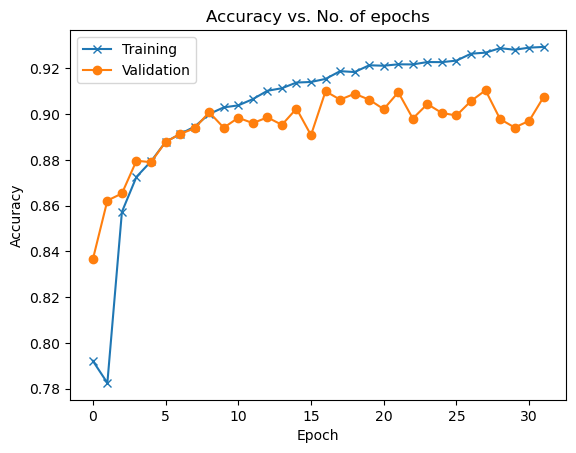

In [33]:
plot_accuracy(train_accuracies, val_accuracies)

In [34]:
def plot_losses(train_losses, val_losses):
    """Plot losses"""
    plt.plot(train_losses, "-x")
    plt.plot(val_losses, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of Epochs")

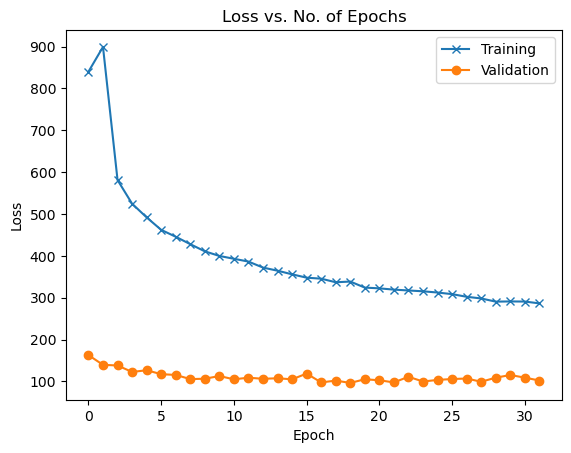

In [35]:
plot_losses(train_losses, val_losses)

## Training

In [61]:
new_model = ImageClassifierNet()
to_device(new_model, device)

In [63]:
indices, _ = split_indices(len(dataset), 0, rand_seed)

sampler = SubsetRandomSampler(indices)
dl = DataLoader(dataset, batch_size, sampler=sampler)
dl = DeviceDataLoader(dl, device)

In [64]:

num_epochs = 10
opt_fn = torch.optim.Adam(new_model.parameters(), lr=0.01)
lr = 0.01

history = train_model(num_epochs, new_model, dl, [], loss_fn, opt_fn, lr)
new_model = history[0]

Epoch 1/10, train_loss: 1032.3443, train_accuracy: 0.7989
Epoch 2/10, train_loss: 812.7200, train_accuracy: 0.8431
Epoch 3/10, train_loss: 651.1084, train_accuracy: 0.8749
Epoch 4/10, train_loss: 604.4463, train_accuracy: 0.8850
Epoch 5/10, train_loss: 563.8647, train_accuracy: 0.8915
Epoch 6/10, train_loss: 537.2177, train_accuracy: 0.8965
Epoch 7/10, train_loss: 519.9920, train_accuracy: 0.9006
Epoch 8/10, train_loss: 496.4650, train_accuracy: 0.9038
Epoch 9/10, train_loss: 490.4798, train_accuracy: 0.9063
Epoch 10/10, train_loss: 476.9829, train_accuracy: 0.9077


## Predictions

In [65]:
def view_prediction(img, label, probs, classes):
    """
    Visualize predictions.
    """
    probs = probs.cpu().numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(8,15), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).cpu().numpy().squeeze(), cmap='Greys_r')
    ax1.axis('off')
    ax1.set_title('Actual: {}'.format(classes[label]))
    ax2.barh(np.arange(10), probs)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(classes, size='small')
    ax2.set_title('Predicted: probabilities')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

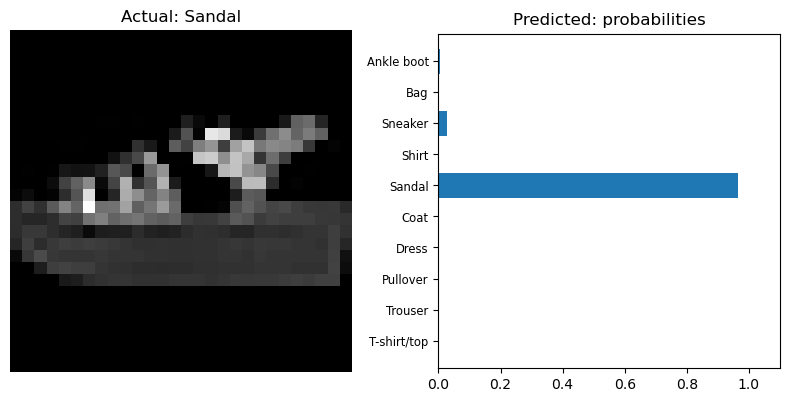

In [66]:
# Calculate the class probabilites (log softmax) for img
images = iter(dl)
for imgs, labels in images:
    with torch.no_grad():
        new_model.eval()
        # Calculate the class probabilites (log softmax) for img
        probs = torch.nn.functional.softmax(new_model(imgs[0].unsqueeze(0)), dim=1)
        # Plot the image and probabilites
        view_prediction(imgs[0], labels[0], probs, dataset.classes)
    break

## Save model

In [67]:
torch.save(new_model, 'new_model')

## Compute accuracy on the test set

In [69]:
import pickle

test_dataset_file_path = "test_data.pickle"

with open(test_dataset_file_path, 'rb') as f:
    test_dataset = pickle.load(f)

In [70]:
test_dl = DataLoader(test_dataset, batch_size)
test_dl = DeviceDataLoader(test_dl, device)

In [71]:
def evaluate(model, test_dl):
    with torch.no_grad():
        model.eval()
        total_test_dl = 0
        preds, labels = [], []
        for xb, yb in test_dl:
            # Model output
            y_pred = model(xb)
            _, y_pred = torch.max(y_pred, dim=1)
            preds.extend(y_pred)
            labels.extend(yb)               
            total_test_dl += len(yb)

    preds, labels = torch.tensor(preds), torch.tensor(labels)
    test_accuracy = torch.sum(preds == labels).item() / len(preds)
    return test_accuracy

In [72]:
print("Test Accuracy = {:.4f}".format(evaluate(new_model, test_dl)))

Test Accuracy = 0.8984
